In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Layer, Input
from keras.layers import Conv2D, Dense, MaxPooling2D, BatchNormalization, Flatten, Dropout, Conv2DTranspose
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model, Sequential
from keras.layers import Concatenate, UpSampling2D
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Define the Dataset Path
path = '/Users/jalalsmac/CVPR/Final/Semantic segmentation of aerial imagery'

#Initialize an Empty List to Store Folder Names
listDir = []

#Iterate Through the Directory and Filter Out
for dir in os.listdir(path):
    if dir != "classes.json":
        listDir.append(dir)

listDir = sorted(listDir)

In [3]:
def loadImg(path, dirTile):
    input_img, mask_img = [], []
    path = os.path.join(path, dirTile)
    inpDir, maskDir = os.listdir(path)

    #Get Image and Mask Directories
    imgDirs = sorted(os.listdir(os.path.join(path, inpDir)))
    #Get Sorted Image and Mask File Lists
    mask_imgDirs = sorted(os.listdir(os.path.join(path, maskDir)))
    
    #Load and Preprocess Input Images
    for imgDir in imgDirs:
        imgDir = os.path.join(path, inpDir, imgDir)
        img = load_img(imgDir, target_size = (224, 224))
        img = tf.convert_to_tensor(img, dtype = tf.float32) / 255.0
        input_img.append(img)

    #Load and Preprocess Mask Images
    for mask_imgDir in mask_imgDirs:
        mask_imgDir = os.path.join(path, maskDir, mask_imgDir)
        mask = load_img(mask_imgDir, target_size = (224, 224))
        mask = tf.convert_to_tensor(mask, dtype = tf.float32) / 255.0
        mask_img.append(mask)
    
    return input_img, mask_img

In [4]:
def loadData(path = path, listDir = listDir):
    imgs_data, masks_data = [], []
    for dirTile in listDir:
        input_imgs, mask_imgs = loadImg(path, dirTile)
        
        imgs_data.extend(input_imgs)
        masks_data.extend(mask_imgs)
    return imgs_data, masks_data

In [5]:
input_imgs, mask_imgs = loadData()

(-0.5, 223.5, 223.5, -0.5)

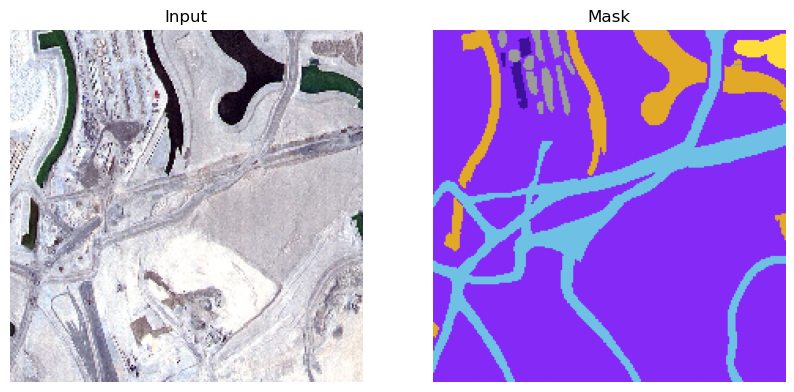

In [6]:
plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(input_imgs[0])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask_imgs[0])
plt.axis("off")

In [7]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_masks, test_masks = train_test_split(input_imgs, mask_imgs, 
                                                                  test_size = 0.2, 
                                                                  shuffle = True, 
                                                                  random_state = 42)

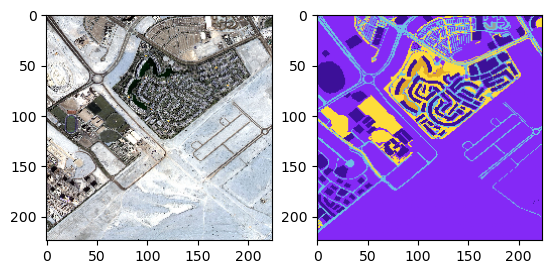

In [8]:
plt.subplot(1, 2, 1)
plt.imshow(train_imgs[1])

plt.subplot(1, 2, 2)
plt.imshow(train_masks[1])

In [9]:
train_data = np.array(list(zip(train_imgs, train_masks)))
test_data = np.array(list(zip(test_imgs, test_masks)))

In [10]:
def Conv(x, dropout, filters):
  x = Conv2D(filters = filters, kernel_size = 3, padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters = filters, kernel_size = 3, padding = 'same', activation = 'relu')(x)
  x = Dropout(dropout)(x)
  pool = MaxPooling2D(pool_size = (2, 2))(x)

  return x, pool

def UpSample(x, skip_connect, dropout, filters):
  x = Concatenate(axis = -1)([skip_connect, UpSampling2D(size = (2, 2))(x)])
  x = Conv2D(filters = filters, kernel_size = 3, padding = 'same', activation = 'relu')(x)
  x = Dropout(dropout)(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters = filters, kernel_size = 3, padding = 'same', activation = 'relu')(x)

  return x

In [11]:
def UNet(x, dropout, conv = [32, 64, 128, 256, 512]):

  # encoder
  conv1, pool1 = Conv(x, dropout, conv[0]) # 224 -> 112
  conv2, pool2 = Conv(pool1, dropout, conv[1]) # 112 -> 56
  conv3, pool3 = Conv(pool2, dropout, conv[2]) # 56 -> 28
  conv4, pool4 = Conv(pool3, dropout, conv[3]) # 28 -> 14

  conv5 = Conv2D(filters = conv[4], kernel_size = 3, padding = 'same', activation = 'relu')(pool4)
  conv5 = Dropout(dropout)(conv5)
  conv5 = BatchNormalization()(conv5)

  # decoder
  conv6 = UpSample(conv5, conv4, dropout, conv[4]) # 14 -> 28
  conv7 = UpSample(conv6, conv3, dropout, conv[3]) # 28 -> 56
  conv8 = UpSample(conv7, conv2, dropout, conv[2]) # 56 -> 112
  conv9 = UpSample(conv8, conv1, dropout, conv[1]) # 112 -> 224

  # output
  result = Conv2D(filters = 3, kernel_size = 1, padding = 'same', activation = 'sigmoid')(conv9)

  return result

In [12]:
input = Input(shape = (224, 224, 3))
output = UNet(input, dropout = 0.1)

model = Model(inputs = input, outputs = output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 224, 224,  │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 112, 112,  │          0 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 56, 56,    │          0 │ conv2d_5[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │    295,168 │ max_pooling2d_2[

 Total params: 10,970,083 (41.85 MB)

 Trainable params: 10,966,179 (41.83 MB)

 Non-trainable params: 3,904 (15.25 KB)

In [13]:
model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [14]:
history = model.fit(np.array(train_imgs), np.array(train_masks),
                    batch_size = 8, 
                    epochs = 10, 
                    validation_data = (np.array(test_imgs), np.array(test_masks)))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - accuracy: 0.5928 - loss: 0.6847 - val_accuracy: 0.7085 - val_loss: 1.5732
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - accuracy: 0.8341 - loss: 0.5779 - val_accuracy: 0.7127 - val_loss: 2.1317
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 56s 7s/step - accuracy: 0.8847 - loss: 0.5492 - val_accuracy: 0.7083 - val_loss: 1.4006
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.8447 - loss: 0.5745 - val_accuracy: 0.7338 - val_loss: 1.2116
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - accuracy: 0.8359 - loss: 0.5702 - val_accuracy: 0.7218 - val_loss: 1.0296
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 56s 7s/step - accuracy: 0.8905 - loss: 0.5423 - val_accuracy: 0.7358 - val_loss: 0.6487
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - accuracy: 0.8750 - loss: 0.5501 - val_accuracy: 0.7201 - val_loss: 0.6532
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.8905 - loss: 0.5567 - val_accuracy: 0.8237 - val_loss: 0.6177
Epoch 9/

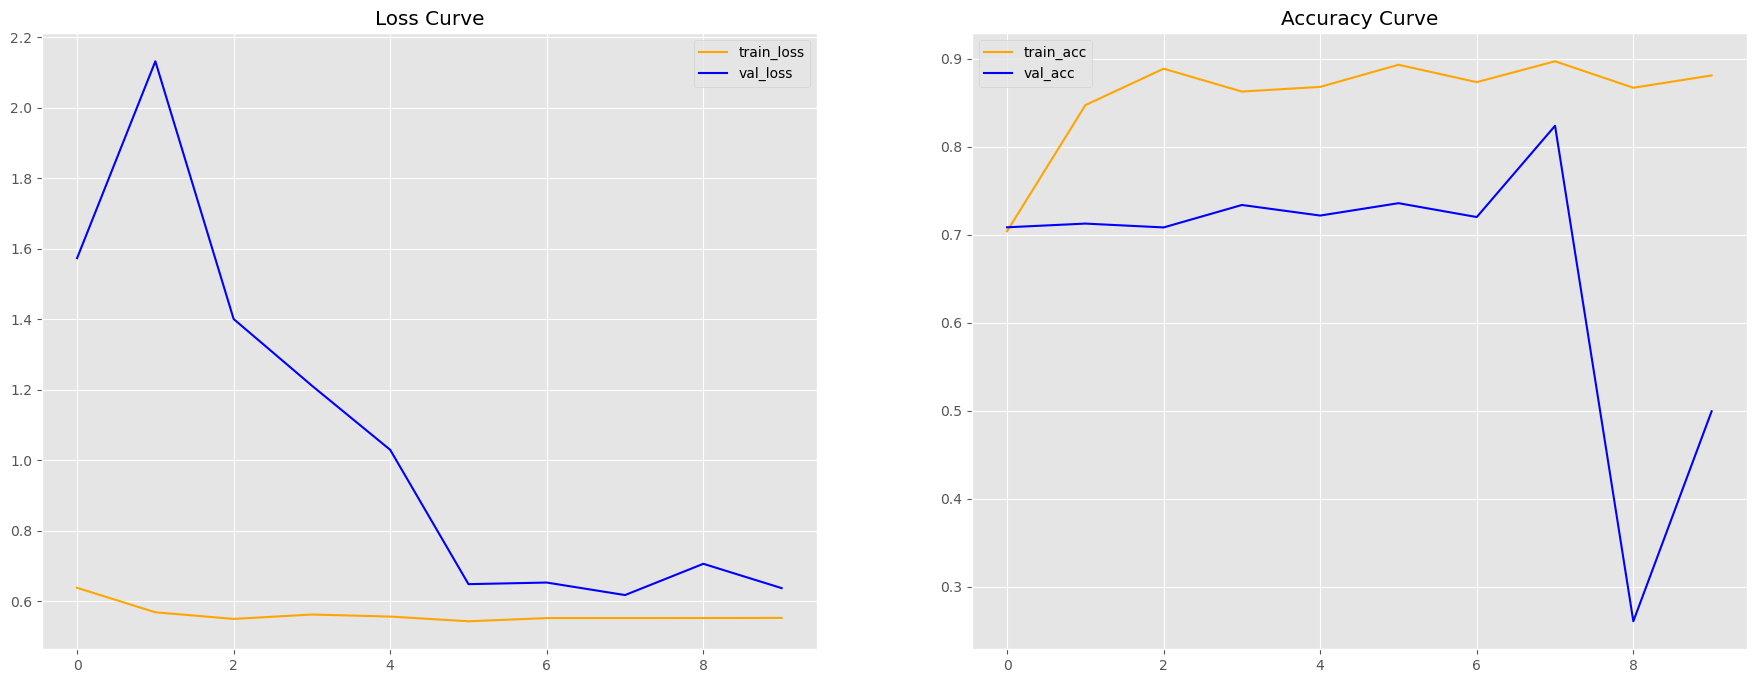

In [24]:
# Use a default Matplotlib style
plt.style.use('ggplot')

# Create the figure
plt.figure(figsize=(22, 8))

# First subplot for loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], c='orange', label='train_loss')
plt.plot(history.history['val_loss'], c='blue', label='val_loss')
plt.legend()
plt.title("Loss Curve")

# Second subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], c='orange', label='train_acc')
plt.plot(history.history['val_accuracy'], c='blue', label='val_acc')
plt.legend()
plt.title("Accuracy Curve")

# Show the plots
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


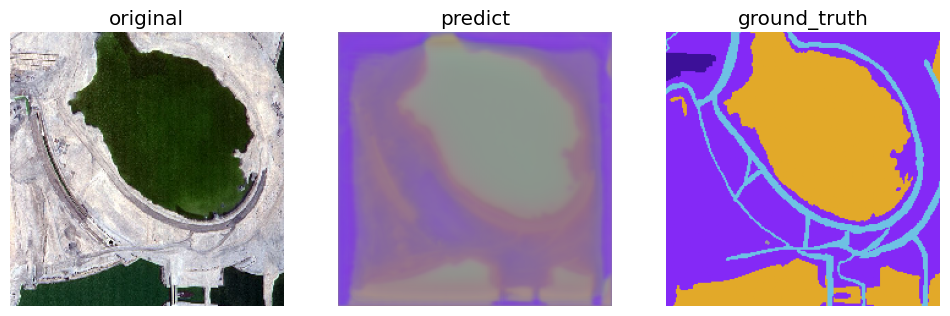

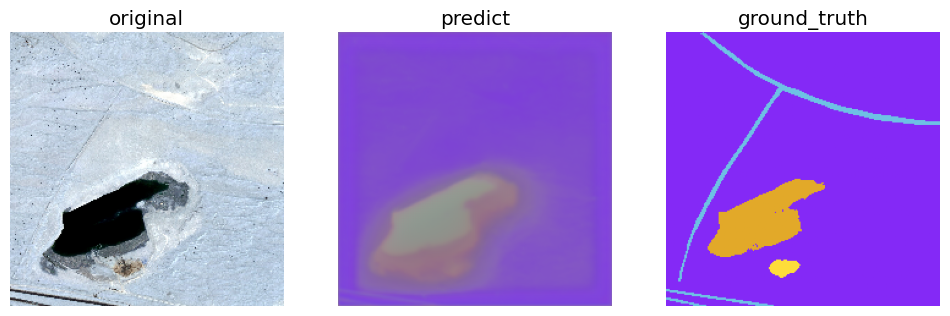

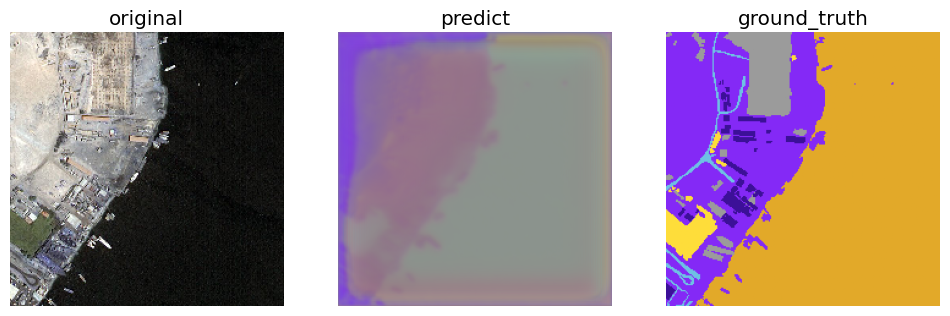

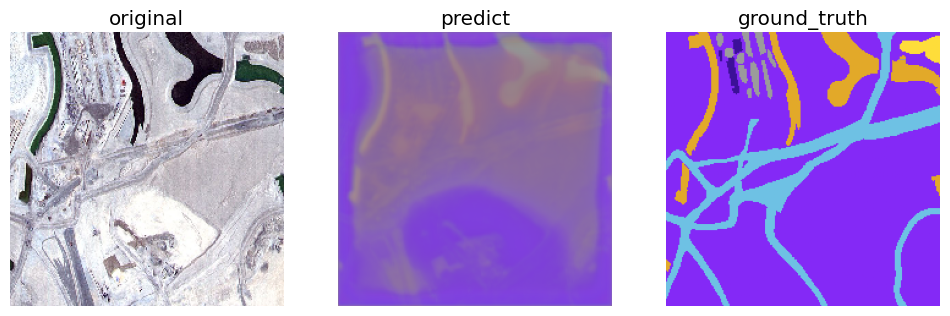

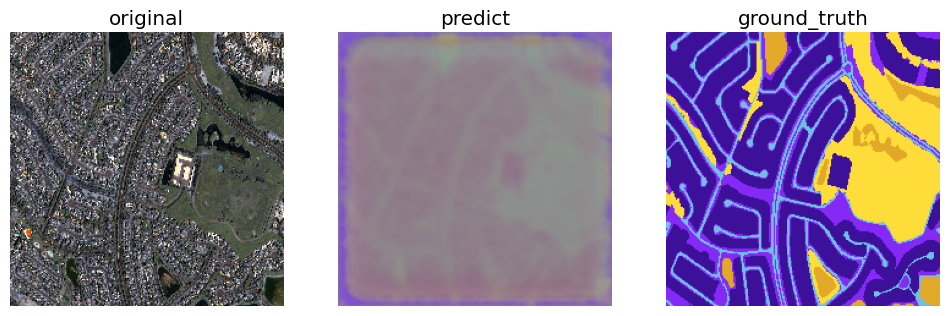

In [26]:
images_predict = model.predict(np.array(test_imgs))
def show_result(id):
    fig, ax = plt.subplots(1, 3, figsize = (12, 7))
    
    ax[0].set_title('original')
    ax[0].imshow(test_imgs[id])
    ax[0].axis("off")
    
    ax[1].set_title('predict')
    ax[1].imshow(images_predict[id])
    ax[1].axis("off")
    
    ax[2].set_title('ground_truth')
    ax[2].imshow(test_masks[id])
    ax[2].axis("off")

for id in range(5):
    show_result(id)